# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, local_earthquake_quicklook, data_wrangler, haversine
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [2]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime(2023,1,9,0,0),
                minmagnitude=4.9,
                maxmagnitude=6.4,
                maxradiuskm=1000, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))
 

Returned 10 events


### Choose an event to analyze

In [3]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df




#event_df.iloc[0::]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
9,nc73827571,2023-01-01 18:35:04.510,"15km SE of Rio Dell, CA",40.409000,-123.971000,30.630,5.35,yellow,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1352
8,nc73821046,2022-12-20 10:39:02.360,"7km WNW of Rio Dell, CA",40.522833,-124.188167,26.550,4.92,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,458
7,nc73821036,2022-12-20 10:34:24.770,"15km WSW of Ferndale, CA",40.525000,-124.423000,17.910,6.40,orange,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1780
6,us6000j8c6,2022-12-10 03:17:30.125,"257 km W of Ferndale, California",40.622100,-127.305900,11.051,4.90,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,372
5,us7000ishe,2022-11-26 03:50:17.526,"18 km NW of Tofino, Canada",49.271400,-126.092300,33.380,4.90,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,527
4,us7000irbr,2022-11-21 15:42:33.590,None,43.487400,-127.338200,10.000,5.20,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,429
3,us7000hhik,2022-06-15 11:56:33.191,off the coast of Oregon,44.538100,-130.112400,10.000,5.60,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,487
2,us7000hf29,2022-06-04 23:59:10.007,"Haida Gwaii Region, Canada",51.613700,-131.402700,6.610,5.10,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,401
1,us6000hfx7,2022-04-23 21:22:47.948,"185 km W of Port McNeill, Canada",50.472500,-129.689500,10.000,5.30,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,435
0,us7000gxl1,2022-03-27 01:12:22.059,off the coast of Oregon,44.122900,-129.438500,10.000,5.10,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,404


In [4]:
dist_kmarray = []
magnituddarray = []
thisid = []
PGM = []
PGA1 = []
PGA2 = []
PGA3 = []
PGV = []

In [5]:
for index,this_event in event_df.iterrows():
    
    this_id = this_event['id']
    
    this_event_new = event_df[event_df.id==this_id]
    
    latitude_loc = this_event_new['latitude']
    longitude_loc = this_event_new['longitude']
    latitude_ref = 47.60
    longitude_ref = -122.33
    
    coords_1 = (this_event_new.latitude.to_numpy()[0], this_event_new.longitude.to_numpy()[0])
    coords_2 = (47.6531, -122.3079)
    dist_km = geopy.distance.geodesic(coords_1, coords_2).km
    
    #distance = haversine(longitude_loc,latitude_loc,longitude_ref,latitude_ref)
    #print(distance)
    
    if  dist_km  <500:#if when I want to avoid the previus datas
           continue
    magnituddarray.append(this_event_new['magnitude'].to_numpy()[0])
    #distance = haversine(longitude_loc,latitude_loc,longitude_ref,latitude_ref)
    thisid.append(this_id)
    dist_kmarray.append(dist_km)
    #if distance < 500:
    #    continue
    
    print(this_event['id'])
    
    stitle=f"M {this_event_new['magnitude'].to_numpy()[0]}, "\
           f"{this_event_new['location'].to_numpy()[0]}, "\
           f"{str(this_event_new['time'].to_numpy()[0])[0:-10]} UTC"
      

    record_length = 20 #minutes
    t0 = this_event_new['time'].iloc[0]
    
    low_cut = 2
    hi_cut = 10

    try:
        client = Client("IRIS")

        t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
        dt = datetime.timedelta(minutes=record_length)
        t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )
        
        
        pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
        st = client.get_waveforms("UW", "PRIN", "--", "HHZ", t1, t2, attach_response=True)
         #st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
        st2 = client.get_waveforms("UW", "SALO", "--", "HHZ", t1, t2, attach_response=True)
        st3 = client.get_waveforms("UW", "CHIMA", "--", "HHZ", t1, t2, attach_response=True)

        
        st.remove_response(output='ACC', pre_filt=pre_filt)
        st2.remove_response(output='ACC', pre_filt=pre_filt)
        st3.remove_response(output='ACC', pre_filt=pre_filt)
            
        peak_ground_acceleration1 = np.max(np.abs(st[0].data))
        peak_ground_acceleration2 = np.max(np.abs(st2[0].data))
        peak_ground_acceleration3 = np.max(np.abs(st3[0].data))
        PGA1.append(peak_ground_acceleration1)
        PGA2.append(peak_ground_acceleration2)
        PGA3.append(peak_ground_acceleration3)
            

        
    except ValueError:
        continue



nc73827571
nc73821046
nc73821036
us6000j8c6
us7000irbr
us7000hhik
us7000hf29
us6000hfx7
us7000gxl1


# Testing waveforms


In [6]:
#clip = pd.read_csv('Clippedanalisis4.csv')
#clip
#data2['Clipped'] = ['TRUE', 'TRUE','TRUE','FALSE','TRUE','FALSE','FALSE','FALSE','FALSE']
#data2



NameError: name 'data2' is not defined

/tmp/ipykernel_899522/2373990707.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(data2['Event ID'])


(array([0.0e+00, 2.0e-05, 4.0e-05, 6.0e-05, 8.0e-05, 1.0e-04, 1.2e-04,
        1.4e-04, 1.6e-04]),
 [Text(0.0, 0, 'nc73827571'),
  Text(2e-05, 0, 'nc73821046'),
  Text(4e-05, 0, 'nc73821036'),
  Text(6.000000000000001e-05, 0, 'us6000j8c6'),
  Text(8e-05, 0, 'us7000irbr'),
  Text(0.0001, 0, 'us7000hhik'),
  Text(0.00012000000000000002, 0, 'us7000hf29'),
  Text(0.00014000000000000001, 0, 'us6000hfx7'),
  Text(0.00016, 0, 'us7000gxl1')])

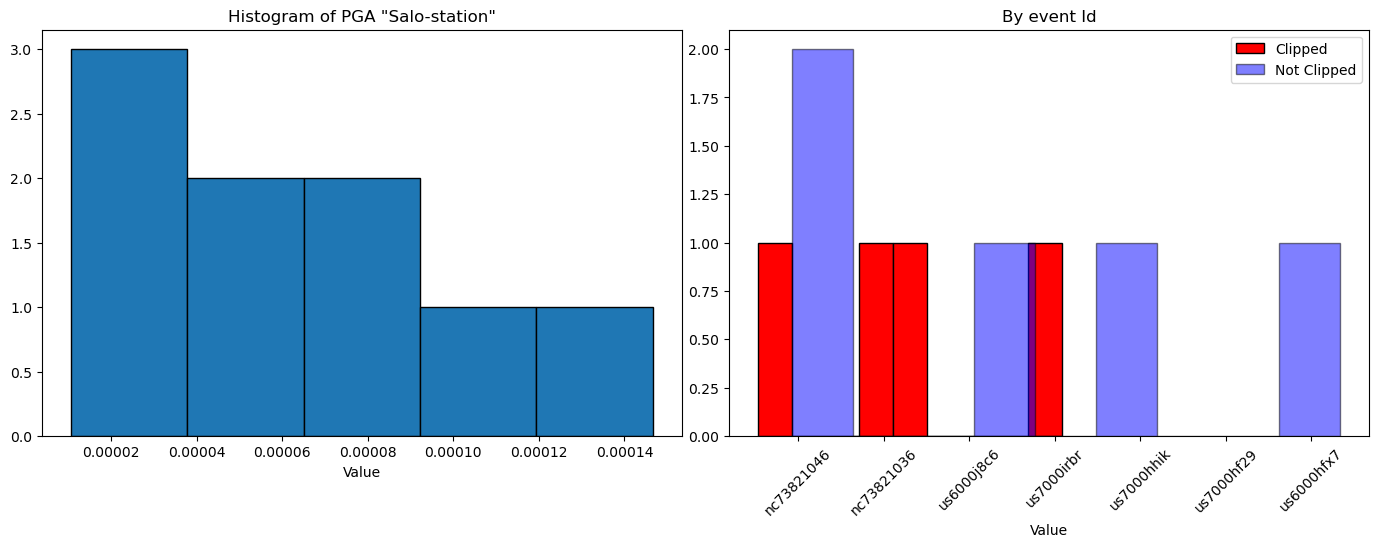

In [32]:
import pandas as pd
import matplotlib.pyplot as plt


data2 = pd.DataFrame({'Event ID': thisid, 'PGA': PGA2})
data2['Clipped'] = ['TRUE', 'TRUE','TRUE','FALSE','TRUE','FALSE','FALSE','FALSE','FALSE']
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Flatten the axes for easier indexing
ax = ax.flatten()

ax[0].hist(data2['PGA'].values,bins=5, edgecolor='black')
ax[0].set_xlabel('Value')
ax[0].set_title('Histogram of PGA "Salo-station"')
plt.tight_layout()
plt.gca().set_xticklabels(data2['Event ID'])
plt.xticks(rotation=45)

# Plot the histogram based on the 'Clipped' column on the second subplot
# Plot the histogram on the second subplot with different colors for clipped and not clipped data
clipped_data = data2[data2['Clipped'] == 'TRUE']['PGA'].values
not_clipped_data = data2[data2['Clipped'] == 'FALSE']['PGA'].values

ax[1].hist(clipped_data, bins=9, edgecolor='black', color='red', label='Clipped')
ax[1].hist(not_clipped_data, bins=9, edgecolor='black', color='blue', alpha=0.5, label='Not Clipped')
ax[1].set_xlabel('Value')
ax[1].set_title('By event Id')
ax[1].legend()

# Adjust spacing between subplots
#plt.tight_layout()
#plt.gca().set_xticklabels(data2['Event ID'])
plt.xticks(rotation=45)



In [ ]:
## second station
data2 = pd.DataFrame({'Event ID': thisid, 'PGA': PGA2})


# Flatten the axes for easier indexing


# Plot the histogram on the first subplot
ax[2].hist(data2['PGA'].values, bins=10, edgecolor='black')
ax[2].set_xlabel('Value')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Histogram of "SALO-station"')
plt.tight_layout()
plt.xticks(rotation=45)
# Plot some other data on the second subplot
# Replace the code below with your desired plot for the second subplot
ax[3].hist(data2['PGA'].values, bins=10, edgecolor='black')
ax[3].set_xlabel('Value')
ax[3].set_ylabel('Frequency')
ax[3].set_title('SALO')

plt.gca().set_xticklabels(data2['Event ID'])
plt.tight_layout()
plt.xticks(rotation=45)
## third station

data3 = pd.DataFrame({'Event ID': thisid, 'PGA-CHIMA': PGA3})


ax[4].hist(data3['PGA-CHIMA'].values, bins=10, edgecolor='black')
ax[4].set_xlabel('Value')
ax[4].set_ylabel('Frequency')
ax[4].set_title('Histogram of "CHIMA-station"')
plt.tight_layout()
plt.xticks(rotation=45)
# Plot some other data on the second subplot
# Replace the code below with your desired plot for the second subplot
ax[5].hist(data3['PGA-CHIMA'].values, bins=10, edgecolor='black')
ax[5].set_xlabel('Value')
ax[5].set_ylabel('Frequency')
ax[5].set_title('Histogram with id events')
plt.gca().set_xticklabels(data3['Event ID'])


# Adjust spacing between subplots
plt.tight_layout()
plt.xticks(rotation=45)


# Show the plot
plt.show()

In [15]:
data2?
